In [0]:
# Importing all the modules that we need:

import tensorflow as tf 
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import time
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Using TensorFlow backend.


In [0]:
# Load the data:

def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

In [0]:
# Getting the training set and reshaping them based on their individual images based on their size:

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()
trainData = trainData.reshape(-1,28,28,1) # Reshaping the images to be in their visual dimensions.
testData = testData.reshape(-1,28,28,1)
validData = validData.reshape(-1,28,28,1)

In [0]:
# One-hot encoding for the training, validation, and test labels:

trainTarget = to_categorical(trainTarget) 
testTarget = to_categorical(testTarget)
validTarget = to_categorical(validTarget)

In [0]:
# The CNN model:

model = tf.keras.models.Sequential()
# 32 (3 x 3) kernels are used with ReLU. 'SAME' method was used for padding. Kernel weights and bias are initialized as Xavier.
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides = (1,1), padding='same', activation='relu', kernel_initializer = tf.keras.initializers.glorot_normal(), input_shape=(28,28,1)))
model.add(tf.keras.layers.BatchNormalization()) # Normalizes the output to prevent unwanted biases.
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # (2 x 2) Max-Pooling kernels.
model.add(tf.keras.layers.Flatten()) # Flattens images for the fully-connected layers.
model.add(tf.keras.layers.Dense(784, activation='relu')) # ReLU is used for each of the 784 neurons in the 1st fully connected layer.
model.add(tf.keras.layers.Dropout(0.9)) # Dropout of 90% probability.
model.add(tf.keras.layers.Dense(10)) # 2nd fully-connected layer.
model.add(tf.keras.layers.Softmax()) # Softmax function for predictions.

In [0]:
# Setting hyperparameters:

batchsize = 32 # Batch size
epochs = 50
l_r = 1e-04 # Learning rate

In [0]:
# Setting the optimization method:

opt = 'ADAM'
opt_SGD = tf.keras.optimizers.SGD(learning_rate = 1e-04)
opt_adam = tf.keras.optimizers.Adam(learning_rate = 1e-04) # Adam optimizer is used.

if opt == 'SGD':
  optimizer = opt_SGD
elif opt == 'ADAM':
  optimizer = opt_adam

In [0]:
# Defining the loss function:

ce_loss = tf.keras.losses.categorical_crossentropy # Cross Entropy Loss is used.

In [0]:
# Compiling the model together:

model.compile(optimizer=optimizer, loss=ce_loss, metrics=['accuracy'])

In [0]:
# The callback objected used to produce the loss and accuracy curves for the testing set. Based on the Keras source code.

Callback = tf.keras.callbacks.History
class TestSets(Callback):
    def __init__(self, test_sets):
        
        super(TestSets, self).__init__()
        self.test_sets = test_sets
        self.epoch = []
        self.history = {}

    def on_train_begin(self, logs=None):
        self.epoch = []
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.epoch.append(epoch)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        for test_set in self.test_sets:
            test_data, test_targets = test_set # Unpacks the target and data.

            results = self.model.evaluate(x=test_data, y=test_targets, batch_size=32) # Evaluates at the end of each epoch.

            for i, result in enumerate(results):
                if i == 0:
                    valuename = 'test_loss' # Identifies the test loss.
                else:
                    valuename = 'test_accuracy' # Identifies the test accuracy.
                self.history.setdefault(valuename, []).append(result) # Loading the test loss and accuracies.

In [0]:
history = TestSets([(testData, testTarget)])

In [0]:
# Training Loop:

model.fit(x=trainData ,y=trainTarget , batch_size=32, epochs=50, callbacks=[history] ,validation_data=(validData, validTarget), shuffle=True, initial_epoch=0) 

Train on 10000 samples, validate on 6000 samples
Epoch 1/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.7417 - acc: 0.7884 - val_loss: 0.7280 - val_acc: 0.8993
Epoch 2/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.3653 - acc: 0.8962 - val_loss: 0.2921 - val_acc: 0.9173
Epoch 3/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.2755 - acc: 0.9209 - val_loss: 0.2616 - val_acc: 0.9238
Epoch 4/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.2200 - acc: 0.9330 - val_loss: 0.2532 - val_acc: 0.9262
Epoch 5/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.1797 - acc: 0.9468 - val_loss: 0.2436 - val_acc: 0.9317
Epoch 6/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.1534 - acc: 0.9544 - val_loss: 0.2441 - val_acc: 0.9315
Epoch 7/50
10000/10000 [==============================] - 29s 3ms/sample - loss: 0.1347 - acc: 0.9571 - val_loss: 0.2

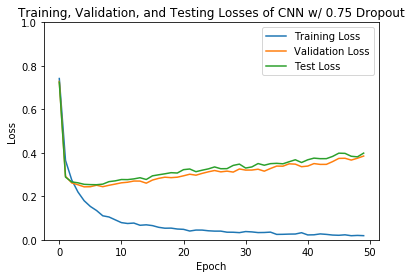

In [0]:
# Plotting the training, validation, and test losses:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Training, Validation, and Testing Losses of CNN w/ 0.75 Dropout')
plt.legend()
plt.show()

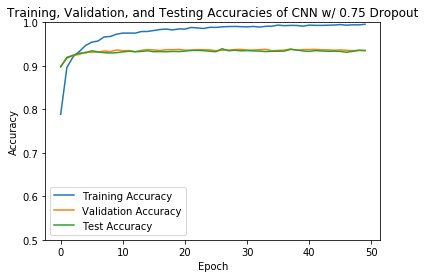

In [0]:
# Plotting the training, validation, and test accuracy:

plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.plot(history.history['test_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1)
plt.title('Training, Validation, and Testing Accuracies of CNN w/ 0.75 Dropout')
plt.legend()
plt.show()